### NCR Digital Banking Fraud Detection Modeling
#### Author: Jermaine Cameron
##### Date: July 2021
##### Datafile: 2020Feb17to26.csv (1.4m instances, 190 labeled fraud)
##### Toolset: Data Science VM in Azure

### Step 1: Install and import python packages

In [1]:
# Install python weka wrapper
# See other requirements information at links below
# https://pypi.org/project/python-weka-wrapper/
# http://fracpete.github.io/python-weka-wrapper3/index.html#requirements

!pip install python-weka-wrapper3

In [2]:
# Install plotly for additional charts

!pip install plotly

In [3]:
# Install python packages typically used with weka. Add / Remove items as needed.

import os
import tempfile
import itertools
import traceback
import numpy as np
import weka.core.jvm as jvm
import matplotlib.pyplot as plt
import weka.plot.classifiers as plot_cls
import plotly.graph_objects as go
import weka.plot.graph as plot_graph
import weka.core.typeconv as typeconv
import weka.core.converters as converters
import plotly.graph_objects as go

from weka.filters import Filter
from weka.core.classes import from_commandline
from weka.core.classes import to_commandline
from weka.classifiers import Evaluation
from weka.core.classes import Random
from weka.filters import Filter
from weka.classifiers import Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random, from_commandline
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier
from weka.classifiers import PredictionOutput, Kernel, KernelClassifier
from weka.experiments import SimpleCrossValidationExperiment, SimpleRandomSplitExperiment, Tester, ResultMatrix

In [4]:
# Manually create plot function to be used later

def plot_confusion_matrix(cm, title):

  plt.gcf().clear()
  fig = plt.figure(1)
  classes = ['No Fraud', 'Fraud']
  plt.imshow(cm, interpolation='none', cmap=plt.cm.BuGn, vmin=0, vmax=255)
  plt.title(title)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = 155
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted') 
  
  image = fig 
  display(image)
  plt.close(fig)

### Step 2: Start Java Virtual Environment for WEKA

In [5]:
# Start Java Virtual Environment for WEKA and allocate memory

import weka.core.jvm as jvm
jvm.start(packages=True,max_heap_size="16g")

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Miniconda\\envs\\py38_default\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Miniconda\\envs\\py38_default\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Miniconda\\envs\\py38_default\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\Miniconda\\envs\\py38_default\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\Miniconda\\envs\\py38_default\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=16g
DEBUG:weka.core.jvm:Package support enabled


### Step 3: Convert CSV file and load data

In [6]:
# Convert csv file to weka arff format and index classification column

data_load = converters.load_any_file("2020Feb17to26.csv", class_index="last-1")
data_convert = converters.save_any_file(data_load,"2020Feb17to26.arff")

In [7]:
# Load arff file and index classification column

loader = Loader(classname="weka.core.converters.ArffLoader")
dataset = loader.load_file("2020Feb17to26.arff", class_index="last-1")

### Step 4: Build and run models with WEKA algorithms

#### Step 4A: Decision Tree

In [8]:
# Build and run decision tree classification model with default options

cls = Classifier(classname="weka.classifiers.trees.J48", options=["-C", "0.3"])
cls.build_classifier(dataset)

#print(cls.to_help()) # Run to_help function to view algorithm description and options details

evl = Evaluation(dataset)
evl.crossvalidate_model(cls, dataset, 10, Random(1))
print(evl.matrix("=== Decision Tree (J48) ==="))

=== Decision Tree (J48) ===
       a       b   <-- classified as
 1402785       0 |       a = NoFraud
     190       0 |       b = Fraud



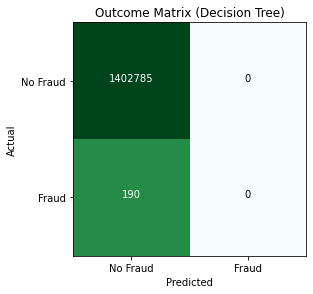

F-Measure: nan
Recall: 0.0


In [9]:
# Create array and print outcome matrix graphic with f measure and recall for positive classifier

DT_matrix = np.array([[1402785, 0],\
                      [190, 0]])
plot_confusion_matrix(DT_matrix, "Outcome Matrix (Decision Tree)")

print("F-Measure: " + str(evl.f_measure(1)))
print("Recall: " + str(evl.recall(1)))

#### Step 4B: Bayesian Network

In [10]:
# Build and run Bayesian Network classificaiton model with default options

Nbn_cmdline = 'weka.classifiers.bayes.BayesNet -D -Q weka.classifiers.bayes.net.search.local.K2 -- -P 1 -S BAYES -E weka.classifiers.bayes.net.estimate.SimpleEstimator -- -A 0.5'
Nbn_cls = from_commandline(Nbn_cmdline, classname="weka.classifiers.Classifier")
Nbn_cls.build_classifier(dataset)

#print(Nbn_cls.to_help()) # Run to_help function to view algorithm description and options details

Nbn_evl = Evaluation(dataset)
Nbn_evl.crossvalidate_model(Nbn_cls, dataset, 10, Random(1))
print(Nbn_evl.matrix("=== Bayes Network ==="))

=== Bayes Network ===
       a       b   <-- classified as
 1401756    1029 |       a = NoFraud
       0     190 |       b = Fraud



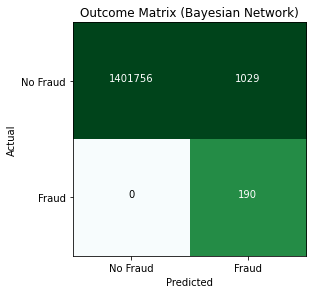

F-Measure: 0.269694819020582
Recall: 1.0


In [11]:
# Create array and print outcome matrix graphic with f measure and recall for positive classifier

Nbn_matrix = np.array([[1401756, 1029],\
                       [0, 190]])
plot_confusion_matrix(Nbn_matrix, "Outcome Matrix (Bayesian Network)")

print("F-Measure: " + str(Nbn_evl.f_measure(1)))
print("Recall: " + str(Nbn_evl.recall(1)))

#### Step 4C: Bayesian Network Ensemble

In [12]:
# Build and run Bayesian Network model with adaptive boosting ensemble algorithm

B_Nbn_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.bayes.BayesNet -- -D -Q weka.classifiers.bayes.net.search.local.K2 -- -P 1 -S BAYES -E weka.classifiers.bayes.net.estimate.SimpleEstimator -- -A 0.5'
B_Nbn_cls = from_commandline(B_Nbn_cmdline, classname="weka.classifiers.Classifier")
B_Nbn_cls.build_classifier(dataset)

#print(B_Nbn_cls.to_help()) # Run to_help function to view algorithm description and options details

B_Nbn_evl = Evaluation(dataset)
B_Nbn_evl.crossvalidate_model(B_Nbn_cls, dataset, 10, Random(1))
print(B_Nbn_evl.matrix("=== AdaBoost Bayes Network ==="))

=== AdaBoost Bayes Network ===
       a       b   <-- classified as
 1402640     145 |       a = NoFraud
       0     190 |       b = Fraud



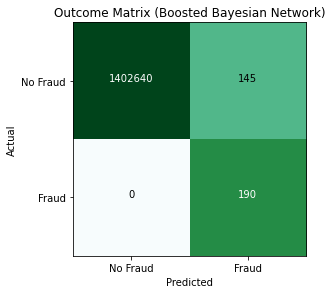

F-Measure: 0.7238095238095238
Recall: 1.0


In [13]:
# Create array and print outcome matrix graphic with f measure and recall for positive classifier

B_Nbn_matrix = np.array([[1402640, 145],\
                         [0, 190]])
plot_confusion_matrix(B_Nbn_matrix, "Outcome Matrix (Boosted Bayesian Network)")

print("F-Measure: " + str(B_Nbn_evl.f_measure(1)))
print("Recall: " + str(B_Nbn_evl.recall(1)))

#### Step 4D: Decision Stump Ensemble

In [14]:
# Build and run Decision Stump model with adaptive boosting ensemble algorithm 

B_DS_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.trees.DecisionStump'
B_DS_cls = from_commandline(B_DS_cmdline, classname="weka.classifiers.Classifier")
B_DS_cls.build_classifier(dataset)

#print(B_DS_cls.to_help()) # Run to_help function to view algorithm description and options details

B_DS_evl = Evaluation(dataset)
B_DS_evl.crossvalidate_model(B_DS_cls, dataset, 10, Random(1))
print(B_DS_evl.matrix("=== AdaBoost Decision Stump ==="))

=== AdaBoost Decision Stump ===
       a       b   <-- classified as
 1402778       7 |       a = NoFraud
       0     190 |       b = Fraud



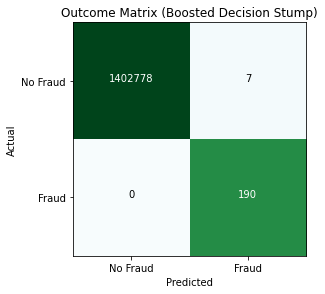

F-Measure: 0.9819121447028424
Recall: 1.0


In [15]:
# Create array and print outcome matrix graphic with f measure and recall for positive classifier

B_Nbn_matrix = np.array([[1402778, 7],\
                         [0, 190]])
plot_confusion_matrix(B_Nbn_matrix, "Outcome Matrix (Boosted Decision Stump)")

print("F-Measure: " + str(B_DS_evl.f_measure(1)))
print("Recall: " + str(B_DS_evl.recall(1)))

#### Step 4E: Bayesian Network Ensemble w/o IP Address Attribute

In [16]:
# Filter dataset to exclude IP address column (2nd column in dataset)

remove = Filter(classname="weka.filters.unsupervised.attribute.Remove", options=["-R", "2"])
remove.inputformat(dataset)
dataset_filtered = remove.filter(dataset)

In [17]:
# Build and run Bayesian Network model without IP address attribute and with adaptive boosting ensemble algorithm

NoIP_B_Nbn_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.bayes.BayesNet -- -D -Q weka.classifiers.bayes.net.search.local.K2 -- -P 1 -S BAYES -E weka.classifiers.bayes.net.estimate.SimpleEstimator -- -A 0.5'
NoIP_B_Nbn_cls = from_commandline(NoIP_B_Nbn_cmdline, classname="weka.classifiers.Classifier")
NoIP_B_Nbn_cls.build_classifier(dataset_filtered)

#print(NoIP_B_Nbn_cls.to_help()) # Run to_help function to view algorithm description and options details

NoIP_B_Nbn_evl = Evaluation(dataset_filtered)
NoIP_B_Nbn_evl.crossvalidate_model(NoIP_B_Nbn_cls, dataset_filtered, 10, Random(1))
print(NoIP_B_Nbn_evl.matrix("=== AdaBoost Bayes Network w/o IP ==="))

=== AdaBoost Bayes Network w/o IP ===
       a       b   <-- classified as
 1402618     167 |       a = NoFraud
      22     168 |       b = Fraud



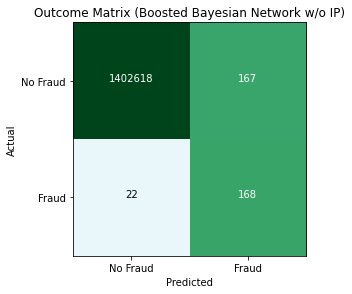

F-Measure: 0.6399999999999999
Recall: 0.8842105263157894


In [18]:
# Create array and print outcome matrix graphic with f measure and recall for positive classifier

NoIP_B_Nbn_matrix = np.array([[1402618, 167],\
                         [22, 168]])
plot_confusion_matrix(NoIP_B_Nbn_matrix, "Outcome Matrix (Boosted Bayesian Network w/o IP)")

print("F-Measure: " + str(NoIP_B_Nbn_evl.f_measure(1)))
print("Recall: " + str(NoIP_B_Nbn_evl.recall(1)))

### Step 5: Close Java Virtual Environment for WEKA

In [19]:
# Stop JVM. May need to restart compute cluster or jupyter kernal if jvm restart is required.

# jvm.stop()